# Encoders: Binary Convolutional Example
We've seen how we can do classifiers on single and on series data and we've seen how we can build classifiers on series. The next logical step is to try and do some encoders on series data. 

Much like the encoder examples on single transactions, we'll have an `Encoder` encoding/compressing the data and a `Decoder` decoding/decompressing the data. But rather than using linear layers, like for the single transactions, we'll be using some of the layers we saw in the series classifiers. We'll start with a __Convolutional__ example as that is the more straight-forward case.

Remember that __Convolutional__ layers slide a filter over the data, reconstructing the original input. (See the series/stacked/classifiers/*convolutional* classifier example for more information). The convolutions sort of compressed the data, each patch of data over which the filter slides gets reduced to a single number, we used *Torch* `Conv1d` layers. 

That operation has an inverse, `ConvTranspose1d`. It gets its name because it is the transpose of the __convolutional matrix__ as used by `Conv1d` layers. We won't go into the technical details of this, but; the  conv-filters do not actually slide over the data, that would be too slow, the 'sliding and multiplying' logic is implemented as matrix multiplication with a __convolutional matrix__. And by transposing that matrix we get an operation that does more or less the same but rather than shrinking the data, it 'expands' the data back out.

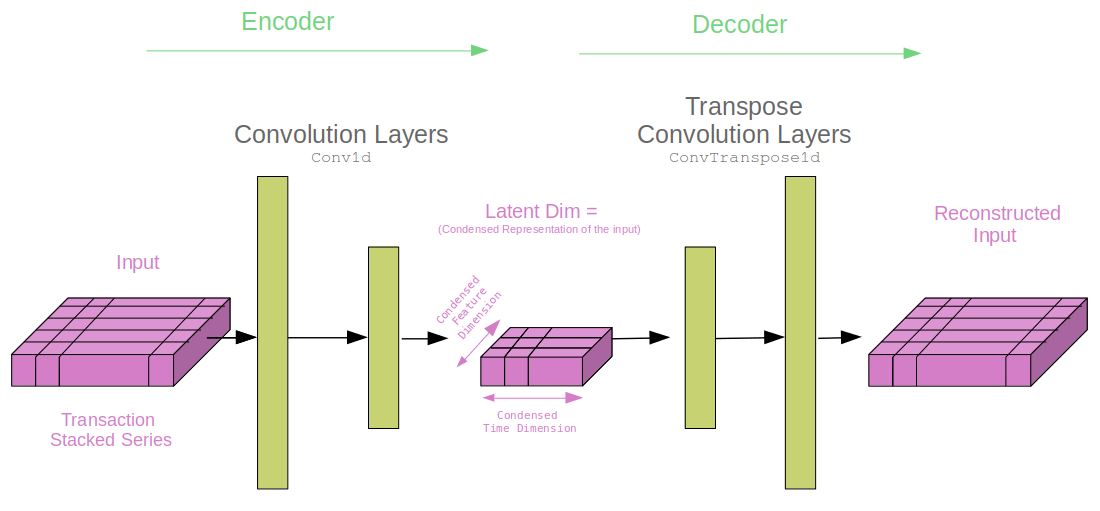 

A Convolutional Encoder will take a series as input and will apply various __convolutional layers__ to condense that input into a latent representation. Other than with the *'single'* transaction encoders, this latent shape is a __2-D tensor__ like the input record. It's feature axis (depth/height) will be reduced. But note that the *time dimension (width)* will also be condensed. 

The time is reduced according to formula; $Time Dimension = \frac {inputlength - kernelsize + 2 * padding} {stride} + 1$ applied in __each filter__; it is potentially applied multiple times.

The Convolutional Decoder does the exact opposite and reconstructs the latent dimension back to the size of the original input. It reconstructed the entire series, rather than a single transaction in the previous 'single' auto-encoder examples.

----
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

# Imports

In [1]:
import torch
import numpy as np
import gc
import datetime as dt

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

# Function to calculate the date and time from the step
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        customer,
        step,
        age,
        gender,
        merchant,
        category,
        amount_binned,
        fraud
    ])

amount_oh = ft.FeatureOneHot('amount_one_hot', amount_binned)
age_oh = ft.FeatureOneHot('age_one_hot', age)
gender_oh = ft.FeatureOneHot('gender_one_hot', gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', merchant)
category_oh = ft.FeatureOneHot('category_one_hot', category)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)


learning_features = ft.TensorDefinition(
    'learning', 
    [
        customer,
        date_time,
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_oh,
        fraud_label
    ])


with en.EnginePandasNumpy(num_threads=8) as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    trx_df  = e.from_df(learning_features, df, inference=False)
    series_list = e.to_series_stacked(
        trx_df, learning_features, key_field=customer, time_field=date_time, length=5
    )

learning_features.remove(customer)
learning_features.remove(date_time)
    
print('Series Shapes')
print(series_list.shapes)
print(series_list.dtype_names)

2020-12-28 11:24:19.671 d373c7.engines.common          INFO     Start Engine...
2020-12-28 11:24:19.671 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-28 11:24:19.671 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-28 11:24:19.672 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2020-12-28 11:24:19.884 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-12-28 11:24:19.897 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)
2020-12-28 11:24:19.898 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2020-12-28 11:24:19.917 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 8)
2020-12-28 11:24:19.917 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode 

Series Shapes
[(594643, 5, 107), (594643, 1)]
['int8', 'int8']


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

For auto-encoders we perform a 5th step, all fraud records will be removed from the training and validation data. The auto-encoder will only see *non-fraud* records during training.
> 1. Remove fraud records from training and validation


In [5]:
test_records = 100000
val_records  = 30000
maturation   = 30000

train_data, val_data, test_data = series_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

# Filter. Only keep non-fraud records with label 0. 
train_data = train_data.filter_label(learning_features, 0)
val_data = val_data.filter_label(learning_features, 0)

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del series_list
gc.collect()
print('Done')

Training Data shapes [(429311, 5, 107), (429311, 1)]
Validation Data shapes [(29670, 5, 107), (29670, 1)]
Test Data shapes [(100000, 5, 107), (100000, 1)]
Done


## Set-up Devices

In [7]:
device, cpu = pt.init_devices()

2020-12-28 11:24:29.434 d373c7.pytorch.common          INFO     Torch Version : 1.7.1+cu110
2020-12-28 11:24:29.481 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-12-28 11:24:29.481 d373c7.pytorch.common          INFO     Cuda Version  : 11.0


## Build the model

> In this example we use a `BinaryToBinaryConvolutionalAutoEncoder` model, that means both input and output will be exclusively binary. We're asking it to use 2 convolutional layers. The encoder layer reduces to __32 features/channels with a kernel_size of 2__, the second layer further reduces to __6 features/channels with a kernel_size of 1__. The decoder layer uses the exact same layers but reversed.

In [8]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSet(learning_features, train_data)
val_ds = pt.NumpyListDataSet(learning_features, val_data)

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.BinaryToBinaryConvolutionalAutoEncoder(
    learning_features, [(32,2), (6,1)]
)
print(m)

BinaryToBinaryConvolutionalAutoEncoder(
  Number of parameters : 14471
  (encoder): LatentCNNEncoder(
    (head): TensorDefinitionHead(lcs=['Binary'])
    (body): ConvolutionalEncoder(
      (conv_layers): Sequential(
        (conv_01): Conv1d(107, 32, kernel_size=(2,), stride=(1,))
        (relu_01): ReLU(inplace=True)
        (conv_02): Conv1d(32, 6, kernel_size=(1,), stride=(1,))
      )
    )
  )
  (decoder): LatentCNNDecoder(
    (latent): ConvolutionalDecoder(
      (conv_layers): Sequential(
        (conv_01): ConvTranspose1d(6, 32, kernel_size=(1,), stride=(1,))
        (relu_01): ReLU(inplace=True)
        (conv_02): ConvTranspose1d(32, 107, kernel_size=(2,), stride=(1,))
        (norm_02): BatchNorm1d(107, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (out): SigmoidOut(
    (sigmoid): Sigmoid()
  )
)


Grapically this model looks more or less like below.

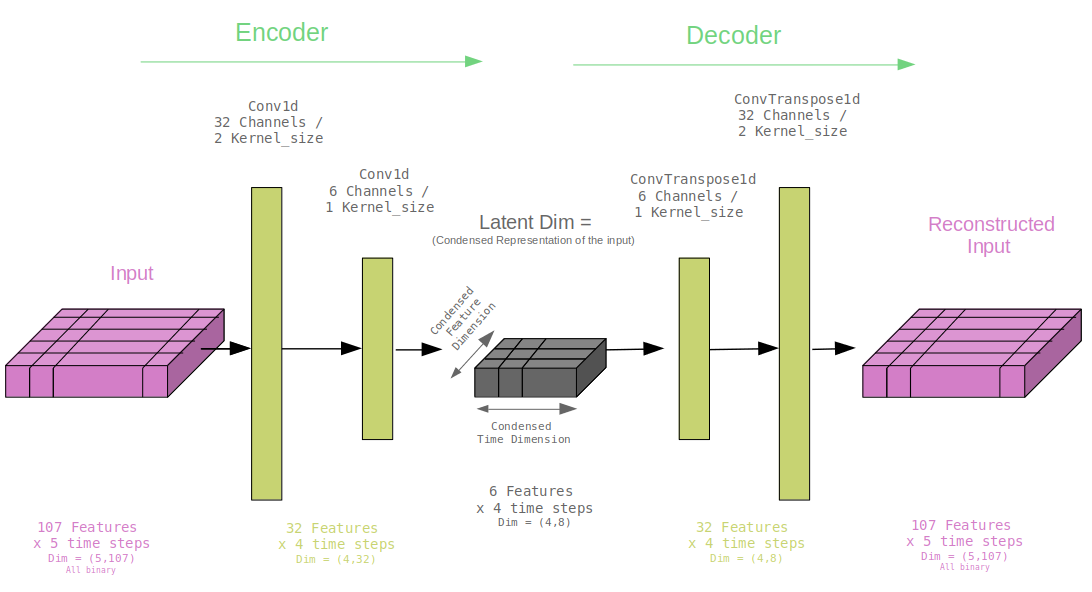


# Start Training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2020-12-28 11:24:35.160 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 233.00it/s]
2020-12-28 11:24:37.340 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


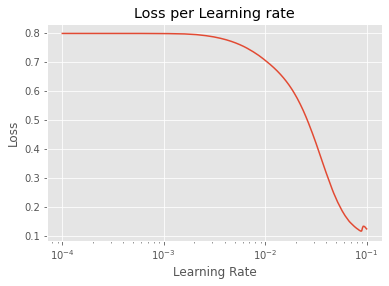

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __5 epochs__ and __learning rate 2e-2__. That means we run over the total training data set a total of 5 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

One thing we can observe is that there is quite a 'systematic' difference in the loss for training and validation. Intuitively we'd expect these to be closer together. There are only non-fraud records, so the loss should in the same ball-park. It's normal that in the beginning the training loss is bigger, the first steps will incur a lot of loss, but we'd expect them to converge in this case. We might go back and look at the data to see if we can spot a reason for this.

Epoch 005/005: 100%|██████████| 3586/3586 [00:11<00:00, 303.43it/s, train_loss=0.0701, val_loss=0.0008]


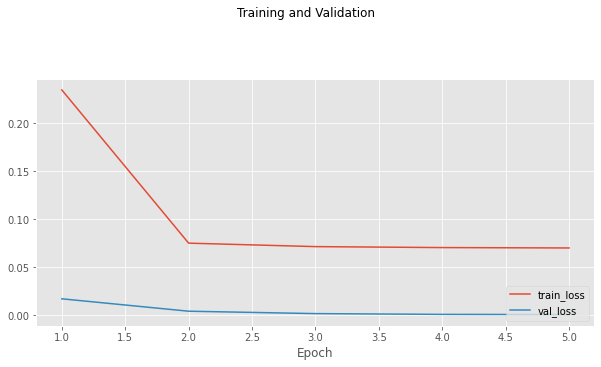

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(5, 2e-2)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data
> Our first 'series' auto-encoder does not seem to do a bad job. As was the case with the 'single' transaction encoders it turn out that the fraud series (where the last payment is the fraud) are more difficult to reconstruct, thus tend to have higher scores.

Creating Scores in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 1095.68it/s]


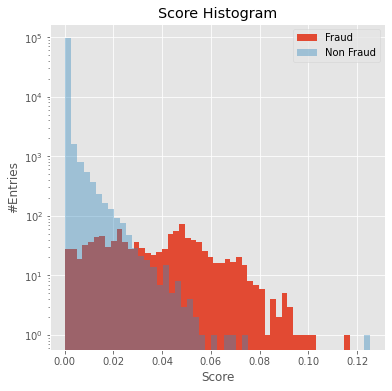

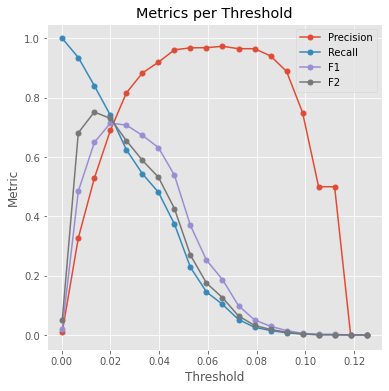

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.69      0.74      0.71      1074

    accuracy                           0.99    100000
   macro avg       0.84      0.87      0.86    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9855
ap score  : 0.7881
-----------------------------------------------------


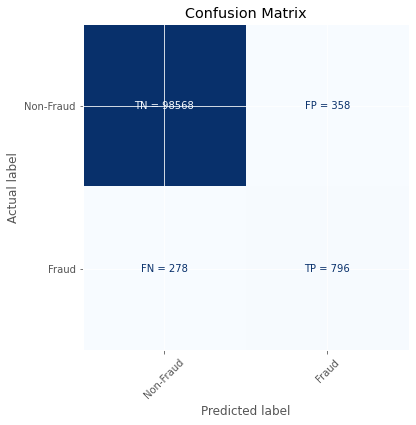

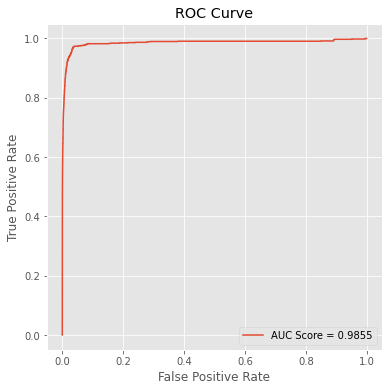

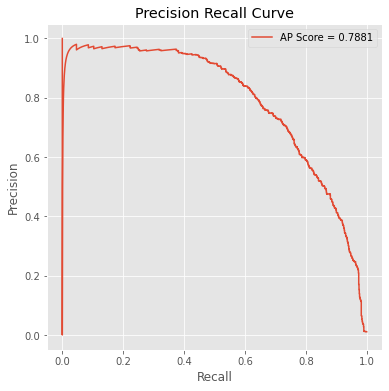

In [12]:
test_ds = pt.NumpyListDataSet(learning_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
tp = pl.TestPlot()
r = ts.score_plot()
tp.plot_scores(r, 50, fig_size=(6,6))
tp.plot_score_metrics(r, 20, fig_size=(6,6))
tp.print_classification_report(r, threshold=0.020)
tp.plot_confusion_matrix(r, fig_size=(6,6), threshold=0.020)
tp.plot_roc_curve(r, fig_size=(6,6))
tp.plot_precision_recall_curve(r, fig_size=(6,6))

# Conclusion
Being very careful about the data, as usual, but we see that asking the model to reconstruct the payments leading up to the fraud might have given the model more to work with. It's not really fair to compare this model (having much more parameters) to the models of single encoders. But these results might confirm our intuition that the transactions leading up to the fraud allow us to better asses abnormality.

Again, note this model __was not shown what fraud looks like__ during training, it only ever saw non-fraud transactions which is was asked to reconstruct.

And these models could probably be improved.
- We have not included information about the time difference between the transactions.
- We could make the series longer.
- And can use more complex convolutional blocks like 'inception' or 'resnet' style blocks.
- During testing on this data it seems the repetition of referential customer attributes like age and gender have a slight negative impact on the model performance.